# Task 5 – Analysis of distributed data sources
## 5.1 Data Initialization + Exploration

Load dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB as bayes
from sklearn.feature_extraction.text import CountVectorizer as countvec
from sklearn.metrics import accuracy_score as accuracy
from sklearn.ensemble import RandomForestClassifier 

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Task**: Import pickled from 'data/twitterData.pkl' and show its shape.
(https://docs.python.org/3/library/)

In [2]:
data = pd.read_pickle('data/twitterData.pkl')
data.shape

(2916, 6)

**Task**: Output some elements of the data set. What do you observe? Are there users without tweets? Check it.

In [3]:

data[data['tweets_concatenated'] == ''].shape

(430, 6)

**Task**: Now remove the users without tweets.

In [4]:
data = data[data['tweets_concatenated'] != '']
data.shape

(2486, 6)

In [5]:
data.iloc[0:10]

,screen_name,name,tweets_concatenated,avatar_url,gender,age
0,DatZerooo,David,Warum riecht mein Bruder nach Pizza wenn er ei...,http://pbs.twimg.com/profile_images/7569661512...,M,16.0
0,reap705,Oliver Gast,[CSS] Ein Off-canvas-Menü mit Dropdown-Navigat...,http://pbs.twimg.com/profile_images/1366984169...,M,15.0
0,eduUu06,eduUu,heut abend kogge und morgen endlich haare ab :...,http://pbs.twimg.com/profile_images/896480580/...,M,46.0
0,Narutofreak935,Avengar,@GrandlineTV gib nicht auf und mach dein Ding ...,http://pbs.twimg.com/profile_images/7317971734...,F,19.0
0,miley_sarah,Sarah,"RT @bomelino: Das ""Backe, backe Kuchen""-Lied i...",http://pbs.twimg.com/profile_images/7584397626...,M,18.0
0,DerIncubus,Der Incubus,@NicoleAllm Na ... gut ins neue Jahr gestartet...,http://pbs.twimg.com/profile_images/5808649200...,F,22.0
0,Petouser,ペトユサ (Petoyusa),Verschwörungstheorie: Pokemon Go wird von der ...,http://pbs.twimg.com/profile_images/6626943925...,M,26.0
0,ChrisWhite126,Chris White,Ach du scheiße ist das warm. :( Hab locker 5kg...,http://pbs.twimg.com/profile_images/6463341220...,M,37.0
0,MusicFreakFever,Nadine (:,Heute nur DREI (!) Schulstunden !\n Ich LIIIIE...,http://pbs.twimg.com/profile_images/3788000003...,M,15.0
0,LukasAlthoff,Luk Alt,RT @cem_oezdemir: #Pazar will mir eine Ehrenbü...,http://pbs.twimg.com/profile_images/5035102215...,F,30.0


**Task**: Insert an additional feature `gender_class` by replacing: 0 = F and 1 = M..

In [6]:
data['gender_class'] = data['gender'].replace({'F': 0, 'M': 1})

**Task**: There are two target attributes in our data set (gender and age). Analyze the distribution of our observation along those attributes.

In [7]:
data.describe()

,age,gender_class
count,1137.000000,2486.000000
mean,22.794195,0.544650
std,12.000068,0.498103
min,3.000000,0.000000
25%,16.000000,0.000000
50%,19.000000,1.000000
75%,24.000000,1.000000
max,82.000000,1.000000


**Task**: Plot the distribution of the gender attribute.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a102e4320>,
      dtype=object)

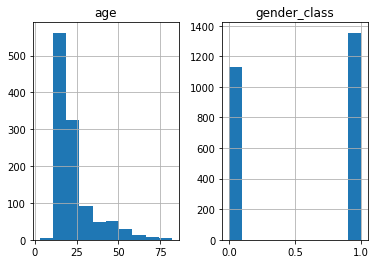

In [8]:
%matplotlib inline  
data.hist()

**Task**: Plot the distribution of the age data set along the following segments: 0-10, 10-20, 20-30 and 30+

*Note: use [pandas.cut()](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html)*

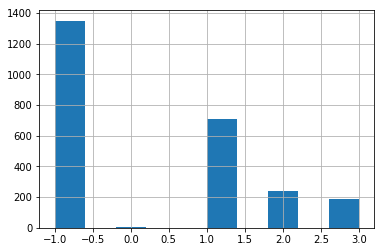

In [9]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 100)])

pd.cut(data['age'], bins=bins,).cat.codes.hist()

## 5.2 Tweet analysis

Our main goal is to train multiple classifiers that can later be combined, based on the user's tweets and their name. However, a multi-step learning model requires three splits on the data: a sub training set, a meta training set and a test set. 

**Task**: Split the data into two trainings (trainSub, trainMeta) and one test set (test).

In [10]:
trainSub, tempData = train_test_split(data, test_size=0.4)
trainMeta, test = train_test_split(tempData, test_size=0.4)
print(trainSub.shape, trainMeta.shape, test.shape)

(1491, 7) (597, 7) (398, 7)


As we only need the tweets or name for a specific observation, we need to extract those.

**Task**: For every subset of our data, extract tweets (trainSub_tweets, trainMeta_tweets, test_tweets) and names from the data.

In [11]:
trainSub_tweets = trainSub['tweets_concatenated']
trainMeta_tweets = trainMeta['tweets_concatenated']
test_tweets = test['tweets_concatenated']

trainSub_names = trainSub['name']
trainMeta_names = trainMeta['name']
test_names = test['name']

**Task**: Also extract the target column for each dataset (y_trainSub, y_trainMeta, y_test).

In [12]:
y_trainSub = trainSub['gender_class']
y_trainMeta = trainMeta['gender_class']
y_test = test['gender_class']

**Task**: Examine your data frames and check their validity

In [13]:
print(trainSub_tweets.iloc[0:1], y_trainSub.iloc[0:1])

0    @ReginaHickups @itsandresjenny ich dich auch||...
Name: tweets_concatenated, dtype: object 0    1
Name: gender_class, dtype: int64


**Tweet Classification Model with Bag of Words Approach**

**Task:** Use a [Bag of Words Approach](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and train a classification model on `trainSub_tweets`.

In [14]:
countvectorizer_tweets = countvec()
x_trainSub_tweets = countvectorizer_tweets.fit_transform(trainSub_tweets)
x_trainMeta_tweets = countvectorizer_tweets.transform(trainMeta_tweets)
x_test_tweets = countvectorizer_tweets.transform(test_tweets)

In [15]:
bayes_tweets = bayes()
bayes_tweets.fit(x_trainSub_tweets, y_trainSub)
tweet_score = bayes_tweets.score(x_test_tweets, y_test)
tweetScore_text = "Tweet Score is {:0.2%}".format(tweet_score)
print(tweetScore_text)

Tweet Score is 68.84%


In [16]:
stacked_input1 = pd.Series(bayes_tweets.predict(x_trainMeta_tweets))
stacked_input1_test = pd.Series(bayes_tweets.predict(x_test_tweets))

**Task**: Print out the feature names and examine them.

In [17]:
countvectorizer_tweets.get_feature_names()

['00',
 '000',
 '0000',
 '00002',
 '0000x',
 '0001',
 '00010111_',
 '000bürger',
 '000daumen',
 '000e',
 '000er',
 '000ghmezhk',
 '000km',
 '000sten',
 '001',
 '0010',
 '00100000',
 '00137',
 '001l',
 '002',
 '003',
 '0039',
 '004',
 '00417kwgfp',
 '005',
 '0058',
 '006',
 '007',
 '00701288304',
 '008',
 '009',
 '00aba5t2un',
 '00blacknwhites',
 '00c1ehquw9',
 '00ck3iezqz',
 '00ct',
 '00dp9d9vza',
 '00emqf6et7',
 '00er',
 '00franz04',
 '00h',
 '00jjdsazpp',
 '00ljgfgxwz',
 '00ljkiqvhl',
 '00m',
 '00marfkrrg',
 '00mxjxx0vg',
 '00o6lci0sb',
 '00oder',
 '00paetq04c',
 '00qdcxkqrb',
 '00qudgh06x',
 '00rah2gvlo',
 '00rmqwwk',
 '00s',
 '00sleepy',
 '00uhr',
 '01',
 '010',
 '01000111',
 '01001000',
 '01001100',
 '01010011',
 '011',
 '01100',
 '01100001',
 '01100011',
 '01100100',
 '01100101',
 '01101001',
 '01101011',
 '01101100',
 '01101101',
 '01101110',
 '01101111',
 '01110000',
 '01110011',
 '01110101',
 '01110111',
 '01111001',
 '012',
 '0123',
 '013',
 '014',
 '01445',
 '0147ktnftw',
 '

## 5.3 Name classifier

### 5.3.1 Name classifier based on name database

It might make sense to include a classifier based on a names database. For that purpose, we rely on a publicly available package.

**Name Classification Model**

**Task**:  Look at the documentation at https://github.com/clintval/gender-predictor. Follow the instructions and test the classifier with the following names: Kathrin, Catherine, Sonja, Xian, Hans, Leonardo.

In [18]:
from gender_predictor import GenderPredictor as genderpred

In [19]:
gender = genderpred()
gender.train_and_test()

import complete
32,031 male names
56,347 female names
classifier accuracy: 96.98%


**Task**: Now test the package on our own data set. For that matter you might need to replace the target attribute of the package to fit our syntax.

In [20]:
y_test2 = test_names.apply(gender.classify)
y_test2.replace({'F': 0, 'M': 1}, inplace=True)
y_test2.head()

0    0
0    1
0    1
0    1
0    1
Name: name, dtype: int64

In [21]:
nameScore1 = accuracy(y_test2, y_test, normalize=True)
nameScore_text1 = "Name Score is {:0.2%}".format(nameScore1)
print(nameScore_text1)

Name Score is 62.31%


In [22]:
stacked_input2 = trainMeta_names.apply(gender.classify)
stacked_input2.replace({'F': 0, 'M': 1}, inplace=True)

stacked_input2_test = test_names.apply(gender.classify)
stacked_input2_test.replace({'F': 0, 'M': 1}, inplace=True)

stacked_input2.index = stacked_input1.index
stacked_input2_test.index = stacked_input1_test.index

**Task**: Why is the score so low? Try to analyze the output in regard to our data.


In [23]:
print(data['name'].iloc[1:10])

0        Oliver Gast
0              eduUu
0            Avengar
0              Sarah
0        Der Incubus
0    ペトユサ (Petoyusa)
0        Chris White
0          Nadine (:
0            Luk Alt
Name: name, dtype: object


### 5.3.1 Name classifier based on ML

An alternative approach can be to also train a machine learning classifier on our names, similar to the text classifier.

**Task**: Now: try it yourself and implement an ML based name classifier and test it.

In [24]:
cvectorizer_names = countvec()
x_trainSub_names = cvectorizer_names.fit_transform(trainSub_names)

x_trainMeta_names = cvectorizer_names.transform(trainMeta_names)
x_test_names = cvectorizer_names.transform(test_names)

# cvectorizer_names.get_feature_names()

In [25]:
bayes_names = bayes()
bayes_names.fit(x_trainSub_names, y_trainSub)
bayes_names.score(x_test_names, y_test)


0.6733668341708543

In [26]:
nameScore2 = bayes_names.score(x_test_names, y_test)
nameScore_text2 = "Name Score is {:0.2%}".format(nameScore2)
print(nameScore_text2)

Name Score is 67.34%


In [27]:
stacked_input3 = pd.Series(bayes_names.predict(x_trainMeta_names))
stacked_input3_test = pd.Series(bayes_names.predict(x_test_names))

## 5.4 Meta classifier 

We now posess three classifiers. As we learned, it should be of use to combine them.

**Ensemble: RandomForest with second training set**

**Task**: Use the three features from above in order to train a Random Forest meta classifier.

In [28]:
# initialize RF classifier
forest = RandomForestClassifier()
# build a pandas df for training and one for testing
# meta training data
meta_data_train = {'input1': stacked_input1, 'input2': stacked_input2, 'input3': stacked_input3}
meta_data_train = pd.DataFrame(meta_data_train)
print(meta_data_train.iloc[0:10])

# meta test data
meta_data_test = {'input1': stacked_input1_test, 'input2': stacked_input2_test, 'input3': stacked_input3_test}
meta_data_test = pd.DataFrame(meta_data_test)
print(meta_data_test.iloc[0:10])

   input1  input2  input3
0       0       0       1
1       0       1       1
2       0       0       0
3       1       1       0
4       1       1       1
5       0       0       1
6       1       1       1
7       1       0       1
8       0       1       1
9       1       1       1
   input1  input2  input3
0       0       0       1
1       0       1       0
2       1       1       1
3       0       1       1
4       0       1       0
5       0       1       1
6       0       1       0
7       0       0       0
8       1       1       1
9       0       1       1


In [29]:
# lets fit the model
forest.fit(meta_data_train, y_trainMeta)

metaScore = forest.score(meta_data_test, y_test)
metaScore_text = "Meta Score is {:0.2%}".format(metaScore)

In [30]:
print(tweetScore_text)
print(nameScore_text1)
print(nameScore_text2)
print(metaScore_text)

Tweet Score is 68.84%
Name Score is 62.31%
Name Score is 67.34%
Meta Score is 72.36%
